# Проект по исследованию некоторых аспектов мобильного приложения.

## Задание 2

#### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.  Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. 

#### A - контрольная группа, B - тестовая группа

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
# выгружаем необходимые библиотеки

import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import norm, mannwhitneyu
from scipy import stats
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# считываем данные
task_2 = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

In [3]:
task_2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


#### Я считаю, что для принятия решения принятия решения стоит проанализировать метрики, такие как ARPU (средний доход на пользователя), ARPPU (средний доход с привлеченного клиента) и CR (конверсию в покупку)

#### с помощью х-квадрата проверяем правильно ли произведено сплитование на группы (по количеству пользователей)

In [6]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(task_2.user_id.count(), task_2.testgroup))
stat, p

(0.0, 1.0)

сплитование на группы проведено верно (p-value > 0.05) и дальше мы можем продолжить исследовать данные, считать нужные нам метрики и проверять есть ли между ними статистически значимые различия

In [7]:
# посчитала количество уникальных пользователей в каждой группе
all_users = task_2.groupby('testgroup', as_index=False)\
    .agg({'user_id':'nunique'})\
    .rename(columns={'user_id':'count_users'})

all_users

,testgroup,count_users
0,a,202103
1,b,202667


Посчитаем количество уникальных клиентов (платящих пользователей):

In [8]:
paying_users = task_2.query('revenue>0')\
    .groupby('testgroup', as_index=False)\
    .agg({'user_id':'nunique'})\
     .rename(columns={'user_id':'paying_users'})

In [9]:
paying_users

,testgroup,paying_users
0,a,1928
1,b,1805


In [16]:
# соединим данные
users = all_users.merge(paying_users, on = 'testgroup')

In [18]:
users['not_paying_users'] = users.count_users - users.paying_users

In [32]:
users

,testgroup,count_users,paying_users,not_paying_users
0,a,202103,1928,200175
1,b,202667,1805,200862


С помощью критерия Х-квадрат проверим соотношение платящих пользователей к общему числу пользователей и неплатящих пользователей к общему числу пользователей в каждой группе:

In [34]:
chi2_contingency(users[['count_users','not_paying_users']].T)

(0.01995199857948413,
 0.887671228288306,
 1,
 array([[202070.80114717, 202699.19885283],
        [200207.19885283, 200829.80114717]]))

In [35]:
chi2_contingency(users[['count_users','paying_users']].T)

(4.294148751290091,
 0.03824373651044168,
 1,
 array([[202166.51498275, 202603.48501725],
        [  1864.48501725,   1868.51498275]]))

Количество неплатящих пользователей статистически значимо не откличается в группах (p-value = 0.88). Однако количество клиентов статистически значимо отличается между собой (p-value = 0.03) и в контрольной группе платящих пользователей больше.

#### Посчитаем коеффициент конверсии
cr = число клиентов/ на общее число пользователей * 100

In [14]:
users['cr'] = users.paying_users/users.count_users*100

In [15]:
users

,testgroup,count_users,paying_users,cr
0,a,202103,1928,0.953969
1,b,202667,1805,0.890624


Видим, что конверсия в покупку в контрольной группе выше, чем в тестовой.

##### Посчитаем ARPU - средний доход с привлеченного ПОЛЬЗОВАТЕЛЯ
ARPU = доход/общее количество пользователей

In [65]:
revenue_per_users = task_2.groupby('testgroup')\
    .agg({'revenue':'sum'})

In [66]:
users = users.merge(revenue_per_users, on='testgroup')

In [67]:
users['arpu'] = users.revenue/users.count_users

####  Посчитаем ARPPU - средний доход с привлеченного КЛИЕНТА
ARPPU = доход/количество клиентов

In [68]:
users['arppu'] = users.revenue/users.paying_users

In [69]:
users

,testgroup,count_users,paying_users,cr,revenue,arpu,arppu
0,a,202103,1928,0.953969,5136189,25.413720,2663.998444
1,b,202667,1805,0.890624,5421603,26.751287,3003.658172


Средний доход с привлеченного пользователя и средний доход с привлеченного клиента в тестовой группе ВЫШЕ, чем в котнрольной.

#### Теперь проверим, статистически значимы ли различия в доходе между тестовой и контрольной группой

##### Формулирую гипотезы:
Есть ли статистически значимых различия в доходе?

H0 - статистически значимых различий между группами нет

H1 - статистически значимые различия между группами есть

In [36]:
# построим boxplot, чтобы наглядно посмотреть есть ли в выбоках выбросы

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

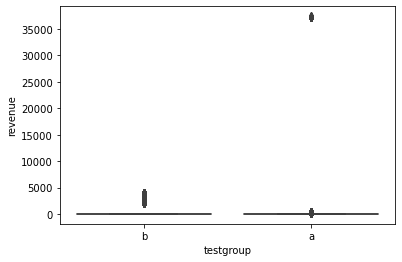

In [37]:
sns.boxplot(x='testgroup',y='revenue', data = task_2)

Видим, что в контрольной группе есть выбросы (экстремально большие значения)

проверим распределения на нормальность. Перед проверкой нужно произвести семплирование, т.к на больших выборках есть вероятность получить неверные результаты

In [38]:
task_2.query('testgroup == "b"').describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


In [39]:
task_2.query('testgroup == "a"').describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [40]:
sample_test_A = task_2[task_2['testgroup'] == 'a']['revenue'].sample(1000, random_state=17)

In [41]:
stats.shapiro(sample_test_A)

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)

In [42]:
sample_test_B = task_2[task_2['testgroup'] == 'b']['revenue'].sample(1000, random_state=17)

In [43]:
stats.shapiro(sample_test_B)

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

По результатам теста Шапиро pvalue=0.0 в обоих случаях - это говорит нам о том, что распределение в группе B так же Не является нормальным. Поэтому сравним выборки с помощью непараметрического аналога - U-критерия Манна-Уитни. Он переводит все данные в рангову шкалу, после этого считает какой средний ранг оказался в первой группе и во второй. Этот критерий менее чувствителен к выбросам

In [44]:
mannwhitneyu(task_2[task_2.testgroup=='a'].revenue,
         task_2[task_2.testgroup=='b'].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

#### При пороге уровня значимости 0,05, получили pvalue=0.06269701316074398, что не позволяет нам отклонить гипотезу Н0.

##### Проверим есть ли статистически значимые различия между группами с помощью bootstrap

In [45]:
# Объявляем функцию, которя позволит проверить гипотезы с помощью бутстрапа
def get_bootstrap_mean(
    data_column_1, # числовые значения для первой выборки
    data_column_2, # числовые значения для второй выборки
    boot_it = 2000, # количество бутстрап_подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.99 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values # True - параметр возвращения
        
        samples_2 = data_column_2.sample(boot_len, replace = True).values # True - параметр возвращения
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean()- применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level)/2
    ci = pd_boot_data.quantile([left_quant,right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data) )
    
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data) )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin = 0, ymax = 50, linestyle = '--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'boot_data' : boot_data,
            'ci' : ci,
            'p_value' : p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

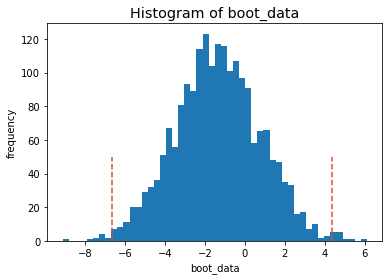

In [46]:
booted_data = get_bootstrap_mean(task_2.query('testgroup=="a"').revenue, task_2.query('testgroup=="b"').revenue)

In [47]:
booted_data['p_value']

0.5231564552061648

In [48]:
booted_data['ci']

,0
0.005,-6.668166
0.995,4.381247


#### pvalue, полученный с помощью bootstrap = 0.5388368631647105, что так же НЕ позволяет нам отклонить гипотезу Н0, о том, что в группах нет статистически значимых различий в доходе.

#### Проверим, есть ли статистически значимые различия между группами в ARPU (в среднем доходе на пользователя)
Предположим, что разлий нет - Н0, различия есть - Н1

In [54]:
task_2

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

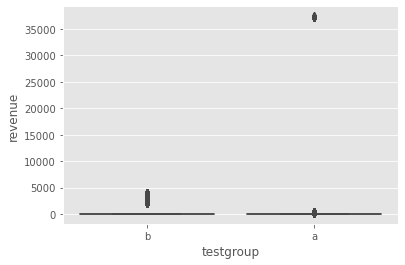

In [55]:
sns.boxplot(x='testgroup',y='revenue', data = task_2)

В контрольной группе есть выбросы

In [69]:
task_2.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


Проверяем выборки на нормальность, предварительно произведя семплирование

In [70]:
sample_test_users_A = task_2[task_2['testgroup'] == 'a']['revenue'].sample(1000, random_state=17)

In [71]:
stats.shapiro(sample_test_users_A)

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)

In [72]:
sample_test_users_B = task_2[task_2['testgroup'] == 'b']['revenue'].sample(1000, random_state=17)

In [73]:
stats.shapiro(sample_test_users_B)

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

##### В обоих группах p-value < 0.05, что говорит нам о НЕ нормальности распределений. Сравним наши выборки с помощью непараметрического аналога - U-критерия Манна-Уитни. Он переводит все данные в ранговую шкалу, после этого считает какой средний ранг оказался в первой группе и во второй. Этот критерий менее чувствителен к выбросам¶

In [74]:
mannwhitneyu(task_2[task_2.testgroup=='a'].revenue,
         task_2[task_2.testgroup=='b'].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

pvalue=0.06 - это значит, что средний доход на пользователя в тестовой и котнрольной группах статистически значимо  НЕ различаются между собой и у нас нет основания отклонить Н0.

#### Теперь посмотрим  есть ли статистически значимые различия между группами в ARPPU (в среднем доходе на клиента)
Предположим, что разлий нет - Н0, различия есть - Н1


In [75]:
paying_df = task_2.query('revenue>0')
# отберем только платящих пользователей и проверим, отличаются ли группы клиентов( платящих пользователей между) собой по доходу   

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

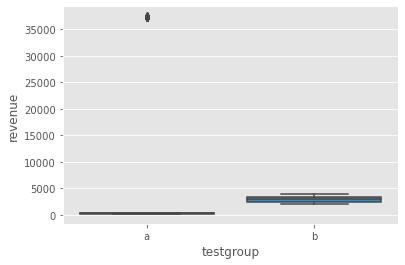

In [76]:
sns.boxplot(x='testgroup',y='revenue', data = paying_df)

##### Видим, что в контрольной группе есть выбросы (экстремально большие значения)

###### проверим распределения на нормальность. Перед проверкой нужно произвести семплирование, т.к на больших выборках есть вероятность получить неверные результаты и уберем выбросы по 0.99 процентилю

In [77]:
paying_df.describe()

,user_id,revenue
count,3733.000000,3733.000000
mean,202900.006161,2828.232521
std,116520.555209,6516.770722
min,73.000000,200.000000
25%,101862.000000,309.000000
50%,202866.000000,2052.000000
75%,301238.000000,3126.000000
max,404768.000000,37433.000000


In [78]:
paying_df = paying_df.loc[paying_df['revenue'] < paying_df.revenue.quantile(q=0.99)]
# отсеила выбросы

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

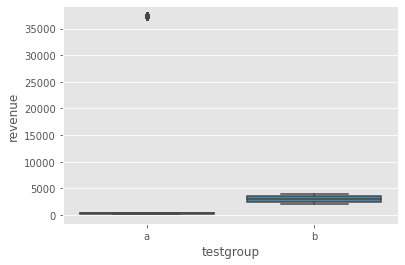

In [79]:
sns.boxplot(x='testgroup',y='revenue', data = paying_df)

In [80]:
# Проверяем выборки на нормальность, предварительно произведя семплирование

In [81]:
sample_test_client_A = paying_df[paying_df['testgroup'] == 'a']['revenue'].sample(1000, random_state=17)

In [82]:
stats.shapiro(sample_test_client_A)

ShapiroResult(statistic=0.22374224662780762, pvalue=0.0)

In [83]:
sample_test_client_B = paying_df[paying_df['testgroup'] == 'b']['revenue'].sample(1000, random_state=17)

In [84]:
stats.shapiro(sample_test_client_B)

ShapiroResult(statistic=0.9613319039344788, pvalue=1.2883664412895895e-15)

##### В обоих группах p-value < 0.05, что говорит нам о НЕ нормальности распределений

###### Сравним наши выборки с помощью непараметрического аналога - U-критерия Манна-Уитни. Он переводит все данные в ранговую шкалу, после этого считает какой средний ранг оказался в первой группе и во второй. Этот критерий менее чувствителен к выбросам

In [85]:
mannwhitneyu(paying_df[paying_df.testgroup=='a'].revenue,
         paying_df[paying_df.testgroup=='b'].revenue)

MannwhitneyuResult(statistic=153425.0, pvalue=0.0)

pvalue=0.0  - это значит, что средний доход платящего пользователя в тестовой и котнрольной группах статистически значимо различаются между собой и у нас есть основания отклонить Н0 и принять гипотезу Н1.

Проверим есть ли статистически значимые различия между группами с помощью bootstrap

In [48]:
def get_bootstrap_median(
    data_column_1, # числовые значения для первой выборки
    data_column_2, # числовые значения для второй выборки
    boot_it = 2000, # количество бутстрап_подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.99 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace = True).values # True - параметр возвращения
        
        samples_2 = data_column_2.sample(boot_len, replace = True).values # True - параметр возвращения
        
        boot_data.append(statistic(samples_1 - samples_2)) # median()- применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level)/2
    ci = pd_boot_data.quantile([left_quant,right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.median(boot_data),
        scale = np.std(boot_data) )
    
    p_2 = norm.cdf(
        x = 0,
        loc = -np.median(boot_data),
        scale = np.std(boot_data) )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin = 0, ymax = 50, linestyle = '--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'boot_data' : boot_data,
            'ci' : ci,
            'p_value' : p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

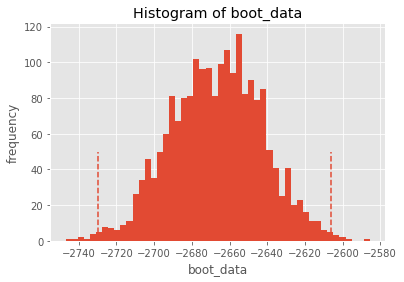

In [49]:
booted_data_2 = get_bootstrap_median(paying_df.query('testgroup=="a"').revenue, paying_df.query('testgroup=="b"').revenue)

In [50]:
booted_data_2['p_value']

0.0

In [51]:
booted_data_2['ci']

,0
0.005,-2730.0025
0.995,-2606.0000


##### По проведенным тестам можно сделать вывод, что общий доход и средний доход с привлеченного пользователя в группах статистически значимо НЕ отличается. Однако, проверив средний доход на платящего пользователя в группах, обнаружили  статистически значимые различия, что  позволяет отклонить Н0  и принять Н1 в том, что средний доход на платящего пользоваталя статистически значимо отличается в группах и в тестовой группе он ВЫШЕ, чем в контрольной группе. Так же в тестовой группе выросла конверсия в покупку и количество платящих пользователей в тестовой группе оказалось статистически значимо больше, при том что общее количество пользователей в группах и количество неплатящих пользователей в группах статистически значимо не отличается.

#### Основываясь на вышесказанном, считаю, что набор предложений тестовой группы лучше и нужно его оставить.

# Задание 3
#### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

#### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

# Ответ:
#### Предлагаю использовать такие метрики как:
##### DAU - дневная аудитория ( количество уникальных пользователей, зашедких в игру в течение дня)
##### MAU - месячная аудитория. И вытекающаю из них метрику stickness ratio - коэффициент того, насколько часто пользователи, в течение одного периода, "остаются" в продукте. Так же важно посмотреть ASL (среднююпродолжительность сессии), чтобы понять как много времени пользователь проводит  в игре.
#### При усложнении механики предлогаю добавить метрику Сonversion rate (коэффициент конверсии). В нашем случае целевым действием будет прохождение уровня. Так же можно посмотреть Churn Rate (коэффициент оттока клиентов), т.е посмотреть какое количество клиентов из предыдущего периода ушло из продукта на момент нового периода.